In [1]:
import cv2
import json
import numpy as np
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Compose, functional as TF
import matplotlib.pyplot as plt 
from tqdm import tqdm, trange

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

class DenoiseImageDataset(Dataset):
    def __init__(self, image_path_list, transform=None):
        """
        Args:
            image_path_list: A pandas dataframe containing 'file_path' and 'label' columns.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_path_list = image_path_list
        self.transform = transform

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, idx):
        input_image = cv2.imread(self.image_path_list[idx], cv2.IMREAD_COLOR)

        if self.transform is not None:
            input_image = self.transform(input_image)

        input_image = TF.resize(input_image, (896, 1152))
        input_image = torch.sigmoid(input_image)
     
        return input_image, self.image_path_list[idx]

def save_to_png(image_path, outputs):
    '''
    image_path(str): new image name
    outputs: 0-1's matrix
    '''
    temp = outputs_temp*255
    matrix = temp.astype(np.uint8)
    image_path = './denoised_ecg/'+image_path[0].split('/')[-1] # Todo Siki updated here
    cv2.imwrite(image_path, matrix)

PATH = './model/UNet_torch.model'
model = torch.load(PATH)
model = model.to(device)
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, a

In [2]:
import glob

#TODO Siki needs to delete use own temp_list

temp_list = glob.glob('/data/padmalab/ecg/data/external/PhysioNet2024_Data/physionet.org/files/ptb-xl/1.0.3/records100_generate_output/records100_generate_output_02000/*.png')
len(temp_list)

998

In [3]:
batch_size = 1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example normalization values
])



test_dataset = DenoiseImageDataset(image_path_list=temp_list, #TODO Siki's input
                                   transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [4]:
np_array_list = []
with tqdm(total=len(test_dataloader)) as pbar:
    for inputs, image_path in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs_temp = outputs.detach().cpu().squeeze().numpy()
        save_to_png(image_path, outputs_temp)
        pbar.update(1)

  0%|▏                                                                                                                                                                                                                                          | 1/998 [00:00<06:38,  2.50it/s]


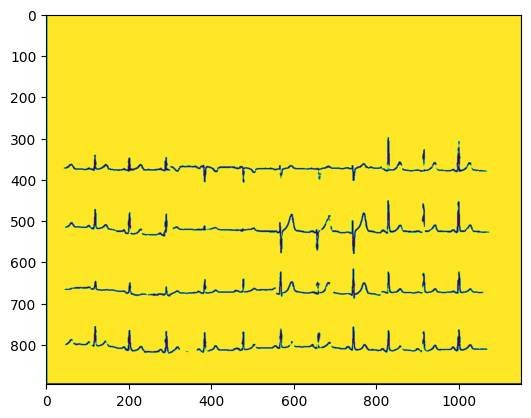

In [5]:
plt.imshow(outputs_temp)